<div dir=rtl>

نام و نام‌خانوادگی: حامد آجورلو

شماره دانشجویی: 97101167

----



<div dir=rtl>

#  آزمايش اول: تأييد و شناسايی هويت با استفاده از FaceNet 

----



<div dir=rtl>


در اين آزمايش می‌خواهيم با استفاده از شبکه FaceNet يک مدل برای تأييد و شناسايی هويت پياده‌سازی کنيم. 

برای دریافت داده‌های مسئله به لینک روبه رو مراجعه کنید:
 [داده‌های مسئله](https://drive.google.com/drive/folders/1PCEqkwjoW7bhr7CFtI4AnXLY4ABYi0kF?usp=sharing)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
import cv2
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf

<div dir=rtl>

## 1.	مدل



الف- بلوک‌  ineption_block_1a را مطابق ساختار ارائه شده تعريف کنيد.

 سپس مدل کلی را کامپایل کرده و معماری کلی آن را نمایش دهید.


ب- تفاوت ساختار inception با شبکه‌های کانولوشنی معمولی چيست؟ مزايای اين ساختار را تحليل کنيد.

ج- در رابطه با تفاوت بین معماری‌های Inception  و ResNet تحقیق کنید.


اختلاف اصلی بین ساختار مدل های اینسپشنی و شبکه های کانولوشنی معمولی در بلوک های اینسپشنی می باشد . این مدل ها تنسور های ورودی را با فیلتر های مختلفی کانوالو می کنند و نتایج را به هم وصل می کنند ولی بر خلاف آن , در شبکه های کانولوشنی معمولی یک کانولوشن روی هر تنسور اعمال می شود. این روش به منظور کاهش پیچیدگی محاسباتی و جلوگیری از اورفیت ارائه شده است و در این دو مسئله نسبت به شبکه های کانولوشنی مزیت دارد . 

معماری شبکه ی مبتنی بر باقی مانده از شبکه ی وی جی جی (ببخشید که فینگلیش نوشتم وقتی انگلیسی نگارش میکنم ترتیب کلمات به هم میریزه) الهام گرفته شده است و شاهکار این معماری در اسکیپ کانکشن های در نظر گرفته شده بین لایه ها می باشد که مشکل صفر شدن مشتق های جزیی را حل میکند. همچنین این اسکیپ کانکشن می تواند لایه هایی که برای عملکرد شبکه مشکل ایجاد میکنند را حذف کند و باعث بهبود شبکه شود





معماری شبکه ی اینسپشن از مجموعه ای از فیلتر ها تشکیل شده است که تنسور های مختلف از فیلتر های مختلف عبور داده شده و درنهایت یک تنسور نهایی را می سازند. به عنوان مثال فرض بفرمایید که قصد داریم بین تصویر سگ ها و گربه ها تمییز قائل شویم . روش اینسپشن روی تنسور مربوط به گوش ها, چشم ها و ... حیوانات فیلتر های مختلف اعمال می کند و با متصل کردن حاصل به تصویر اصلی می رسد و طبقه بندی انجام میدهد . این روش بسیار از لحاظ پیچیدگی محاسباتی بهینه تر است نسبت به شبکه کانولوشنی معمولی

In [ ]:
def conv2d_bn(x,
              layer=None,
              cv1_out=None,
              cv1_filter=(1, 1),
              cv1_strides=(1, 1),
              cv2_out=None,
              cv2_filter=(3, 3),
              cv2_strides=(1, 1),
              padding=None):
    num = '' if cv2_out == None else '1'
    tensor = Conv2D(cv1_out, cv1_filter, strides=cv1_strides, data_format='channels_first', name=layer+'_conv'+num)(x)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+num)(tensor)
    tensor = Activation('relu')(tensor)
    if padding == None:
        return tensor
    tensor = ZeroPadding2D(padding=padding, data_format='channels_first')(tensor)
    if cv2_out == None:
        return tensor
    tensor = Conv2D(cv2_out, cv2_filter, strides=cv2_strides, data_format='channels_first', name=layer+'_conv'+'2')(tensor)
    tensor = BatchNormalization(axis=1, epsilon=0.00001, name=layer+'_bn'+'2')(tensor)
    tensor = Activation('relu')(tensor)
    return tensor

def inception_block_1a(X):

    ### Defining inception block based on mentioned procedure in Lab agenda

    X_3x3 = Conv2D(96,(1,1),data_format='channels_first',name='inception_3a_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1,1),data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128,(3,3),data_format='channels_first',name='inception_3a_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    
    X_5x5 = Conv2D(16,(1,1),data_format='channels_first',name='inception_3a_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2,2),data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(32,(5,5),data_format='channels_first',name='inception_3a_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)


    X_pool = MaxPooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_first')(X)
    X_pool = Conv2D(32,(1,1),data_format='channels_first',name='inception_3a_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4,4),data_format='channels_first')(X_pool)


    X_1x1 = Conv2D(64,(1,1),data_format='channels_first',name='inception_3a_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1,epsilon=0.00001,name='inception_3a_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1b(X):
    X_3x3 = Conv2D(96, (1, 1), data_format='channels_first', name='inception_3b_3x3_conv1')(X)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn1')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)
    X_3x3 = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_3x3)
    X_3x3 = Conv2D(128, (3, 3), data_format='channels_first', name='inception_3b_3x3_conv2')(X_3x3)
    X_3x3 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_3x3_bn2')(X_3x3)
    X_3x3 = Activation('relu')(X_3x3)

    X_5x5 = Conv2D(32, (1, 1), data_format='channels_first', name='inception_3b_5x5_conv1')(X)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn1')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)
    X_5x5 = ZeroPadding2D(padding=(2, 2), data_format='channels_first')(X_5x5)
    X_5x5 = Conv2D(64, (5, 5), data_format='channels_first', name='inception_3b_5x5_conv2')(X_5x5)
    X_5x5 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_5x5_bn2')(X_5x5)
    X_5x5 = Activation('relu')(X_5x5)

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_pool_conv')(X_pool)
    X_pool = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_pool_bn')(X_pool)
    X_pool = Activation('relu')(X_pool)
    X_pool = ZeroPadding2D(padding=(4, 4), data_format='channels_first')(X_pool)

    X_1x1 = Conv2D(64, (1, 1), data_format='channels_first', name='inception_3b_1x1_conv')(X)
    X_1x1 = BatchNormalization(axis=1, epsilon=0.00001, name='inception_3b_1x1_bn')(X_1x1)
    X_1x1 = Activation('relu')(X_1x1)

    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_1c(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_3c_3x3',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))

    X_5x5 = conv2d_bn(X,
                           layer='inception_3c_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))

    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_2a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_4a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=192,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4a_5x5',
                           cv1_out=32,
                           cv1_filter=(1, 1),
                           cv2_out=64,
                           cv2_filter=(5, 5),
                           cv2_strides=(1, 1),
                           padding=(2, 2))

    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_4a_pool',
                           cv1_out=128,
                           cv1_filter=(1, 1),
                           padding=(2, 2))
    X_1x1 = conv2d_bn(X,
                           layer='inception_4a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_5x5, X_pool, X_1x1], axis=1)

    return inception

def inception_block_2b(X):
    #inception4e
    X_3x3 = conv2d_bn(X,
                           layer='inception_4e_3x3',
                           cv1_out=160,
                           cv1_filter=(1, 1),
                           cv2_out=256,
                           cv2_filter=(3, 3),
                           cv2_strides=(2, 2),
                           padding=(1, 1))
    X_5x5 = conv2d_bn(X,
                           layer='inception_4e_5x5',
                           cv1_out=64,
                           cv1_filter=(1, 1),
                           cv2_out=128,
                           cv2_filter=(5, 5),
                           cv2_strides=(2, 2),
                           padding=(2, 2))
    
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = ZeroPadding2D(padding=((0, 1), (0, 1)), data_format='channels_first')(X_pool)

    inception = concatenate([X_3x3, X_5x5, X_pool], axis=1)

    return inception

def inception_block_3a(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5a_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = AveragePooling2D(pool_size=(3, 3), strides=(3, 3), data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5a_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           padding=(1, 1))
    X_1x1 = conv2d_bn(X,
                           layer='inception_5a_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))

    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def inception_block_3b(X):
    X_3x3 = conv2d_bn(X,
                           layer='inception_5b_3x3',
                           cv1_out=96,
                           cv1_filter=(1, 1),
                           cv2_out=384,
                           cv2_filter=(3, 3),
                           cv2_strides=(1, 1),
                           padding=(1, 1))
    X_pool = MaxPooling2D(pool_size=3, strides=2, data_format='channels_first')(X)
    X_pool = conv2d_bn(X_pool,
                           layer='inception_5b_pool',
                           cv1_out=96,
                           cv1_filter=(1, 1))
    X_pool = ZeroPadding2D(padding=(1, 1), data_format='channels_first')(X_pool)

    X_1x1 = conv2d_bn(X,
                           layer='inception_5b_1x1',
                           cv1_out=256,
                           cv1_filter=(1, 1))
    inception = concatenate([X_3x3, X_pool, X_1x1], axis=1)

    return inception

def faceRecoModel(input_shape):
    """
    Implementation of the Inception model used for FaceNet
    
    Arguments:
    input_shape -- shape of the images of the dataset
    Returns:
    model -- a Model() instance in Keras
    """
        
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # First Block
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
    X = BatchNormalization(axis = 1, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D((3, 3), strides = 2)(X)
    
    # Second Block
    X = Conv2D(64, (1, 1), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)

    # Second Block
    X = Conv2D(192, (3, 3), strides = (1, 1), name = 'conv3')(X)
    X = BatchNormalization(axis = 1, epsilon=0.00001, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    # Zero-Padding + MAXPOOL
    X = ZeroPadding2D((1, 1))(X)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    # Inception 1: a/b/c
    X = inception_block_1a(X)
    X = inception_block_1b(X)
    X = inception_block_1c(X)
    
    # Inception 2: a/b
    X = inception_block_2a(X)
    X = inception_block_2b(X)
    
    # Inception 3: a/b
    X = inception_block_3a(X)
    X = inception_block_3b(X)
    
    # Top layer
    X = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, name='dense_layer')(X)
    
    # L2 normalization
    X = Lambda(lambda  x: K.l2_normalize(x,axis=1))(X)

    # Create model instance
    model = Model(inputs = X_input, outputs = X, name='FaceRecoModel')
        
    return model

In [ ]:
model = faceRecoModel(input_shape=(3, 96, 96))

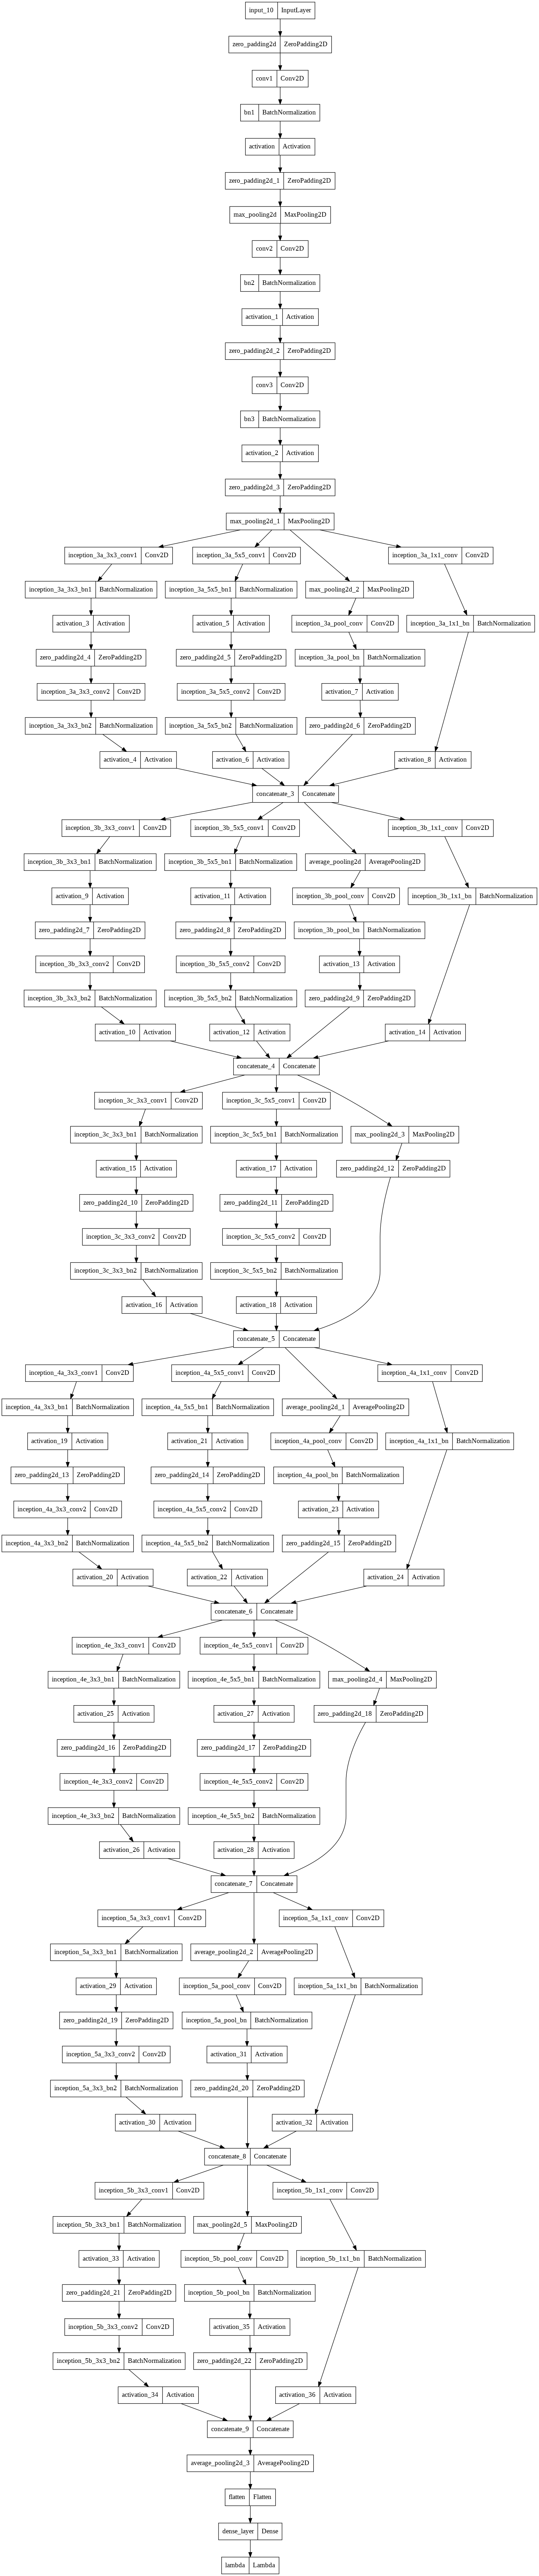

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=False)

In [ ]:
model.summary()

Model: "FaceRecoModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 3, 96, 96)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 3, 102, 102)  0          ['input_10[0][0]']               
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 48, 48)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 bn1 (BatchNormalization)       (None, 64, 48, 48)   256         ['conv1[0][0]']                  
                                                                                      

<div dir=rtl>

## 2.	آموزش شبکه

با توجه به بالا بودن تعداد پارامترهای شبکه و زمان زياد آموزش شبکه، وزن‌های شبکه از پيش محاسبه شده و در فايل ضميمه موجود است. اين وزن‌ها را لود کرده و از آنها استفاده نماييد.



In [ ]:
WEIGHTS = [
  'conv1', 'bn1', 'conv2', 'bn2', 'conv3', 'bn3',
  'inception_3a_1x1_conv', 'inception_3a_1x1_bn',
  'inception_3a_pool_conv', 'inception_3a_pool_bn',
  'inception_3a_5x5_conv1', 'inception_3a_5x5_conv2', 'inception_3a_5x5_bn1', 'inception_3a_5x5_bn2',
  'inception_3a_3x3_conv1', 'inception_3a_3x3_conv2', 'inception_3a_3x3_bn1', 'inception_3a_3x3_bn2',
  'inception_3b_3x3_conv1', 'inception_3b_3x3_conv2', 'inception_3b_3x3_bn1', 'inception_3b_3x3_bn2',
  'inception_3b_5x5_conv1', 'inception_3b_5x5_conv2', 'inception_3b_5x5_bn1', 'inception_3b_5x5_bn2',
  'inception_3b_pool_conv', 'inception_3b_pool_bn',
  'inception_3b_1x1_conv', 'inception_3b_1x1_bn',
  'inception_3c_3x3_conv1', 'inception_3c_3x3_conv2', 'inception_3c_3x3_bn1', 'inception_3c_3x3_bn2',
  'inception_3c_5x5_conv1', 'inception_3c_5x5_conv2', 'inception_3c_5x5_bn1', 'inception_3c_5x5_bn2',
  'inception_4a_3x3_conv1', 'inception_4a_3x3_conv2', 'inception_4a_3x3_bn1', 'inception_4a_3x3_bn2',
  'inception_4a_5x5_conv1', 'inception_4a_5x5_conv2', 'inception_4a_5x5_bn1', 'inception_4a_5x5_bn2',
  'inception_4a_pool_conv', 'inception_4a_pool_bn',
  'inception_4a_1x1_conv', 'inception_4a_1x1_bn',
  'inception_4e_3x3_conv1', 'inception_4e_3x3_conv2', 'inception_4e_3x3_bn1', 'inception_4e_3x3_bn2',
  'inception_4e_5x5_conv1', 'inception_4e_5x5_conv2', 'inception_4e_5x5_bn1', 'inception_4e_5x5_bn2',
  'inception_5a_3x3_conv1', 'inception_5a_3x3_conv2', 'inception_5a_3x3_bn1', 'inception_5a_3x3_bn2',
  'inception_5a_pool_conv', 'inception_5a_pool_bn',
  'inception_5a_1x1_conv', 'inception_5a_1x1_bn',
  'inception_5b_3x3_conv1', 'inception_5b_3x3_conv2', 'inception_5b_3x3_bn1', 'inception_5b_3x3_bn2',
  'inception_5b_pool_conv', 'inception_5b_pool_bn',
  'inception_5b_1x1_conv', 'inception_5b_1x1_bn',
  'dense_layer'
]

conv_shape = {
  'conv1': [64, 3, 7, 7],
  'conv2': [64, 64, 1, 1],
  'conv3': [192, 64, 3, 3],
  'inception_3a_1x1_conv': [64, 192, 1, 1],
  'inception_3a_pool_conv': [32, 192, 1, 1],
  'inception_3a_5x5_conv1': [16, 192, 1, 1],
  'inception_3a_5x5_conv2': [32, 16, 5, 5],
  'inception_3a_3x3_conv1': [96, 192, 1, 1],
  'inception_3a_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_3x3_conv1': [96, 256, 1, 1],
  'inception_3b_3x3_conv2': [128, 96, 3, 3],
  'inception_3b_5x5_conv1': [32, 256, 1, 1],
  'inception_3b_5x5_conv2': [64, 32, 5, 5],
  'inception_3b_pool_conv': [64, 256, 1, 1],
  'inception_3b_1x1_conv': [64, 256, 1, 1],
  'inception_3c_3x3_conv1': [128, 320, 1, 1],
  'inception_3c_3x3_conv2': [256, 128, 3, 3],
  'inception_3c_5x5_conv1': [32, 320, 1, 1],
  'inception_3c_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_3x3_conv1': [96, 640, 1, 1],
  'inception_4a_3x3_conv2': [192, 96, 3, 3],
  'inception_4a_5x5_conv1': [32, 640, 1, 1,],
  'inception_4a_5x5_conv2': [64, 32, 5, 5],
  'inception_4a_pool_conv': [128, 640, 1, 1],
  'inception_4a_1x1_conv': [256, 640, 1, 1],
  'inception_4e_3x3_conv1': [160, 640, 1, 1],
  'inception_4e_3x3_conv2': [256, 160, 3, 3],
  'inception_4e_5x5_conv1': [64, 640, 1, 1],
  'inception_4e_5x5_conv2': [128, 64, 5, 5],
  'inception_5a_3x3_conv1': [96, 1024, 1, 1],
  'inception_5a_3x3_conv2': [384, 96, 3, 3],
  'inception_5a_pool_conv': [96, 1024, 1, 1],
  'inception_5a_1x1_conv': [256, 1024, 1, 1],
  'inception_5b_3x3_conv1': [96, 736, 1, 1],
  'inception_5b_3x3_conv2': [384, 96, 3, 3],
  'inception_5b_pool_conv': [96, 736, 1, 1],
  'inception_5b_1x1_conv': [256, 736, 1, 1],
}

def load_weights_from_FaceNet(FRmodel):
    # Load weights from csv files (which was exported from Openface torch model)
    weights = WEIGHTS
    weights_dict = load_weights()

    # Set layer weights of the model
    for name in weights:
        if FRmodel.get_layer(name) != None:
            FRmodel.get_layer(name).set_weights(weights_dict[name])
        elif model.get_layer(name) != None:
            model.get_layer(name).set_weights(weights_dict[name])

def load_weights():
    # Set weights path
    dirPath = '/content/drive/MyDrive/data/weights'
    fileNames = filter(lambda f: not f.startswith('.'), os.listdir(dirPath))
    paths = {}
    weights_dict = {}

    for n in fileNames:
        paths[n.replace('.csv', '')] = dirPath + '/' + n

    for name in WEIGHTS:
        if 'conv' in name:
            conv_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            conv_w = np.reshape(conv_w, conv_shape[name])
            conv_w = np.transpose(conv_w, (2, 3, 1, 0))
            conv_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            weights_dict[name] = [conv_w, conv_b]     
        elif 'bn' in name:
            bn_w = genfromtxt(paths[name + '_w'], delimiter=',', dtype=None)
            bn_b = genfromtxt(paths[name + '_b'], delimiter=',', dtype=None)
            bn_m = genfromtxt(paths[name + '_m'], delimiter=',', dtype=None)
            bn_v = genfromtxt(paths[name + '_v'], delimiter=',', dtype=None)
            weights_dict[name] = [bn_w, bn_b, bn_m, bn_v]
        elif 'dense' in name:
            dense_w = genfromtxt(dirPath+'/dense_w.csv', delimiter=',', dtype=None)
            dense_w = np.reshape(dense_w, (128, 736))
            dense_w = np.transpose(dense_w, (1, 0))
            dense_b = genfromtxt(dirPath+'/dense_b.csv', delimiter=',', dtype=None)
            weights_dict[name] = [dense_w, dense_b]

    return weights_dict



In [ ]:
load_weights_from_FaceNet(model)

<div dir=rtl>

## 3.	پياده‌سازی سيستم امنیتی خودکار

در اين بخش می‌خواهيم با استفاده از مدل تعريف شده و آموزش ديده، يک سيستم امنیتی خودکار طراحی کنيم که به دو شکل کاربرد دارد:

•	تأييد هويت: در اين بخش تصوير يک شخص به همراه ادعای او (من x هستم) دريافت می‌شود و سيستم امنيتی بايد تصوير شخص را با تصاوير موجود در ديتابيس مطابقت داده و اعلام کند آيا هويت اعلامی او صحيح است يا خير.

•	شناسايی هويت: فرض کنيد 5 نفر کارمند يک شرکت هستند و تصاوير اين اشخاص از پيش در سيستم تعريف شده است. در حالت شناسايی هويت توسط سيستم، بايد تصوير شخص ورودی دريافت شده و با ديتابيس تطبيق داده شود و نتيجه مطابق توضيحات زير بيان شود.


بر اساس توضيحات داده شده، هر يک از گام‌های زير را برای ساخت يک سيستم امنیتی خودکار، تکميل کنيد.



<div dir=rtl>

الف- تشکيل ديتابيس: با استفاده از مدل به دست آمده، فضای embedding هر يک از تصاوير موجود در فولدر ديتابيس را محاسبه کرده و بر اساس آن يک ديتابيس تشکيل دهيد.



In [ ]:
def img_path_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)
    image = cv2.resize(img1, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict_on_batch(x_train)
    return embedding

#make database
database = {}
Address = '/content/drive/MyDrive/data/database'
DataBase = os.listdir(Address)
for filename in DataBase:
  path ='/content/drive/MyDrive/data/database/' +str(filename)
  database[filename[0:-4]] = img_path_to_encoding(path,model)

<div dir=rtl>

ب- تأييد هويت: يک تابع به نام verification بنويسيد که با دريافت تصوير ورودی + نام، ادعا شده، اعلام کند آيا هويت شخص تأييد می‌شود يا خير.

•	خروجی اين تابع شامل فاصله L2، دو embedding ادعا شده و ورودی و همچنين تأييد و يا عدم تأييد شخص براساس حد آستانه 0.7 می‌باشد.

•	خروجی تصاوير موجود در فولدر verif_test را محاسبه کنيد.




In [ ]:
# GRADED FUNCTION: verify

def verify(image_path, identity, database, model):
    encoding = img_path_to_encoding(image_path, model)
    dist = np.linalg.norm(encoding - database[identity],2)
    Flag = False
    if(dist<=0.7):
      Flag = True
    return dist, Flag  

In [ ]:
for i in os.listdir('/content/drive/MyDrive/data/verif_test'):
  path = '/content/drive/MyDrive/data/verif_test/' + str(i)
  dist , flag = verify(path,"Arnold_Palmer",database,model)
  print("flag and distance = " ,flag,dist,path)

flag and distance =  False 0.78979826 /content/drive/MyDrive/data/verif_test/Andre.jpg
flag and distance =  False 0.9081266 /content/drive/MyDrive/data/verif_test/Andy.jpg
flag and distance =  False 0.7768867 /content/drive/MyDrive/data/verif_test/Anna.jpg
flag and distance =  True 0.6559201 /content/drive/MyDrive/data/verif_test/Arnold.jpg


می بینیم که شبکه عملکرد مناسبی ندارد!

در واقع فقط تصویر آرنولد را توانسته است که تایید کند و تصاویر اندی و آنا و آندره را نتوانسته است راستی آزمایی کند.

<div dir=rtl>

شناسايی چهره: يک تابع به نام recognition بنويسيد که با دريافت تصوير ورودی، نام شخص را در صورت وجود در ديتابيس و در غير اينصورت not found را اعلام کند.

•	خروجی تصاوير موجود در فولدر recog_test را محاسبه کنيد.





In [ ]:
def recognition(image_path, database, model):
    encoding = img_path_to_encoding(image_path, model)
    min_dist = 100
    for (name, enc) in database.items():
      dist = np.linalg.norm(encoding - database[name],2)
      if(dist<=min_dist):
        identity = name 
        min_dist = dist
    if(min_dist>0.7):
      identity = 'not found'

    return min_dist, identity  

In [ ]:
for i in os.listdir('/content/drive/MyDrive/data/recog_test'):
  path = '/content/drive/MyDrive/data/recog_test/' + str(i)
  print(i)
  dist , id = recognition(path,database,model)
  print("Distance & Identity = " ,dist,id)

test1.jpg
Distance & Identity =  0.63326955 Anna_Kournikova
test2.jpg
Distance & Identity =  0.7571447 not found
test3.jpg
Distance & Identity =  0.620469 Andy_Roddick
test4.jpg
Distance & Identity =  0.7869203 not found


در این قسمت نیز شبکه عملکرد چندان مطلوبی ندارد و تصویر آرنولد را با اندی اشتباه گرفته است و آنگلا مرکل را نیز نتوانسته است با دیتاست مطابقت دهد و تشخیص دهد.

<div dir=rtl>

#  آزمايش دوم: آشنايی با شبکه siamese 

----



<div dir=rtl>

شبکه siamese نوعی شبکه عصبی کانولوشن برای شناسايی تصاوير است تا ميزان شباهت و اختلاف بين ورودی‌ها را بسنجد. به عبارت ديگر، يک شبکه کانولوشن بايد به نحوی آموزش ببيند که برای هر تصوير يک بردار ويژگی محاسبه کند و بردارهای مربوط به تصاوير مشابه، نزديک به يکديگر و در غير اينصورت، متفاوت باشند. 

در اين آزمايش می‌خواهيم يک شبکه Siamese برای شناسايی اعداد با استفاده از ديتاست mnist را آموزش دهيم.

In [ ]:
# loading libraries
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
from keras.layers.merge import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt


<div dir=rtl>

## 1.	دیتاست


 با استفاده از کد زير، داده‌های آموزش و تست را دانلود کنيد و سه نمونه از داده‌های آموزش را همراه با ليبل‌هايشان نمايش دهيد.

In [ ]:
#loading MNIST dataset
from tensorflow.keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


(-0.5, 27.5, 27.5, -0.5)

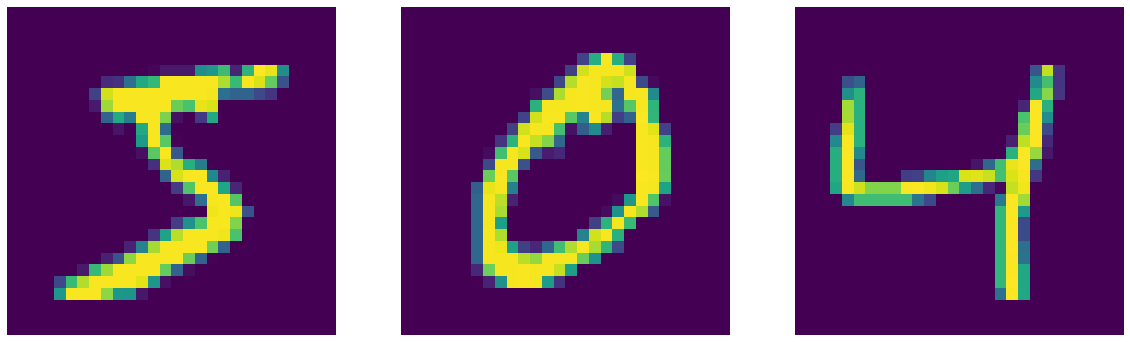

In [ ]:
### plot 3 imgae from dataset
from google.colab.patches import cv2_imshow
plt.figure(figsize=(20,10))
plt.subplot(1, 3, 1)
plt.imshow(X_train[0])
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(X_train[1])
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(X_train[2])
plt.axis('off')

<div dir=rtl>

## 2.	تعریف مدل

مدل شبکه از يک شبکه مرکزی برای محاسبه بردارهايی با طول 48(در اين آزمايش) مربوط به هر تصوير ورودی تشکيل می‌شود. برای آموزش شبکه، همزمان 3 ورودی به شبکه مرکزی اعمال می‌شود:

a.	لنگر (anchor) : تصوير اصلی

b.	تصوير مثبت: مشابهت زياد با تصوير اصلی

c.	تصوير منفی: متمايز با تصوير اصلی

خروجی حاصل متناظر هر ورودی در انتهای شبکه مرکزی با يکديگر ادغام شده و براساس آن مقدار تابع هزينه برای آپديت شبکه مشخص می‌شود. 



In [ ]:
# normalizing images
X_train = X_train / 255.
X_test  = X_test / 255.

In [ ]:
# Siamese network
def embedding(inputs):
  embeddingDim=48
  inputShape=(28,28,1)
  x = Conv2D(32, (3,3),input_shape=inputShape ,activation ='relu' ,kernel_initializer='he_uniform')(inputs)
  x = Conv2D(32, (3,3), activation="relu",kernel_initializer='he_uniform')(x)
  x = Conv2D(32, (5,5),strides =(2,2), padding="same", activation="relu",kernel_initializer='he_uniform')(x)
  x = Conv2D(64, (3,3),strides =(1,1), activation="relu",kernel_initializer='he_uniform')(x)
  x = Conv2D(64, (3,3), activation="relu",kernel_initializer='he_uniform')(x)
  x = Conv2D(64, (5,5),strides =(2,2), padding="same", activation="relu",kernel_initializer='he_uniform')(x)
  x = Conv2D(128, (4,4),strides =(1,1), activation="relu",kernel_initializer='he_uniform')(x)
  pooledOutput = GlobalAveragePooling2D()(x)
  outputs = Dense(embeddingDim)(pooledOutput)
  # build the model
  return outputs

In [ ]:
def sia():
  #input layer for anchor image
  input_anchor = tf.keras.layers.Input(shape = (28, 28, 1))

  #input layer for positive image
  input_positive = tf.keras.layers.Input(shape = (28, 28, 1))

  #input layer for negative image
  input_negative = tf.keras.layers.Input(shape = (28, 28, 1))

  embedding_anchor = embedding(input_anchor)
  embedding_positive = embedding(input_positive)
  embedding_negative = embedding(input_negative)

  embeding = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis = 1)
  model = Model(inputs = [input_anchor, input_positive, input_negative], outputs = embeding)

  return model

model = sia()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 26, 26, 32)   320         ['input_1[0][0]']                
                                                                                              

<div dir=rtl>

## 3.	تعریف دسته

همانطور که مشاهده کرديد، ساختار داده آموزش در زمينه شناسايی چهره و تصوير کمی متفاوت‌تر از ساير حوزه‌های می‌باشد. برای آموزش شبکه در Siamese و با استفاده از تابع هزينه سه‌گانه، لازم است دسته‌هايی شامل 3تايی‌های تصوير اصلی(anchor)، نمونه‌های مثبت و منفی تشکيل دهيم. بر اين اساس تابعی با نام batch_generator تعريف کنيد که به عنوان ورودی، ابعاد دسته را دريافت کرده و به تعداد آن به صورت رندم 3تايی‌ها را مطابق توضيحات بسازد.
راهنمايی: هر بار يک تصوير را به صورت رندم انتخاب کنيد و به عنوان anchor قرار دهيد، سپس نمونه‌هايی که ليبل يکسان و غير يکسان دارند را محاسبه کرده و از هر کدام يک نمونه را به صورت تصادفی انتخاب کنيد.



In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
# increasing dimension of input images across third axis
x_train = np.expand_dims(X_train, axis=3)
x_test = np.expand_dims(X_test, axis=3)


In [ ]:
def create_batch_data(x, y, batch_size = 100):
  samples = x.shape[0]
  anchors = []
  positives = []
  negatives = []
  indexes = np.random.choice(samples,batch_size)
  ### Building similar and different samples
  for i in range(batch_size):
    indx = indexes[i]
    anchors.append(x[i])
    pos_list = np.where(y == y[i])[0].astype(np.int64)
    index_pos = np.random.choice(pos_list,1)[0]
    positives.append(x[index_pos])

    neg_list = np.where(y != y[i])[0].astype(np.int64)
    index_neg = np.random.choice(neg_list,1)[0]
    negatives.append(x[index_neg])

  anchors = np.array(anchors)
  positives = np.array(positives)
  negatives = np.array(negatives)

  return [anchors, positives, negatives]


<div dir=rtl>

## 4.	تعریف تابع هزینه

تابع هزينه را مطابق تابع هزينه سه‌گانه تعريف کنيد.



In [ ]:
# triplet loss
embeding_dim = 48
def Triplet_loss(alpha):
  def get_loss(y_true,y_pred):
    u = 0
    ### implementing given formula
    for i in range(100):
      anchors = y_pred[i,:embeding_dim]
      positives = y_pred[i,embeding_dim:2*embeding_dim]
      negatives = y_pred[i,2*embeding_dim:3*embeding_dim]
      p1 = tf.math.squared_difference(anchors,positives)
      p1 = tf.math.reduce_mean(p1)
      p2 = tf.math.squared_difference(anchors,negatives)
      p2 = tf.math.reduce_mean(p2)
      u += p1 - p2
    u += alpha
    return tf.math.maximum(u,0)
  return get_loss

<div dir=rtl>

## 3.	آموزش شبکه

مدل را با استفاده از تابع هزينه تعريف شده و دسته‌ها آموزش دهيد و نمودار خطای آموزش را به ازای هر تکرار رسم کنيد. (epoch = 5 , batch_size = 100, optimizer = Adam)


In [ ]:
def Data_generator(batch_size):
    while True:
        x = create_batch_data(x_train,Y_train,batch_size)
        y = np.zeros((batch_size, 3*48))

        yield x, y

batch_size = 100
epochs = 5
model.compile(loss = Triplet_loss(alpha = 0.4), optimizer = 'adam')

# training over dataset
history = model.fit(Data_generator(batch_size), 
                    steps_per_epoch = int(x_train.shape[0]/batch_size),
                    epochs = epochs)


Epoch 1/5
600/600 [==============================] - 56s 61ms/step - loss: 0.0022
Epoch 2/5
600/600 [==============================] - 39s 65ms/step - loss: 0.0000e+00
Epoch 3/5
600/600 [==============================] - 37s 61ms/step - loss: 0.0000e+00
Epoch 4/5
600/600 [==============================] - 37s 62ms/step - loss: 0.0000e+00
Epoch 5/5
600/600 [==============================] - 37s 61ms/step - loss: 0.0000e+00


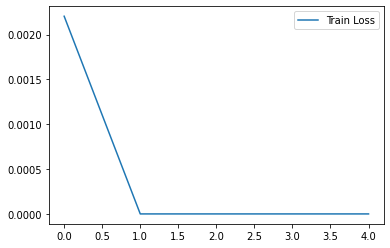

In [ ]:
## plot result
plt.plot(history.history['loss'])
plt.legend(['Train Loss'])

<div dir=rtl>

## 6.	تست شبکه 

6.	برای تست مدل، يک تابع برای محاسبه شباهت بين دو تصوير و براساس cosine similarity بين بردارهای تصاوير بنويسيد. سپس به صورت رندم، يک جفت نمونه مشابه و يک جفت نمونه متمايز انتخاب کنيد و شباهت را بين آنها محاسبه کنيد. حد آستانه مناسب برای دسته‌بندی تصاوير را پيشنهاد دهيد.


In [ ]:
from numpy import linalg as LA
def cosine_similarity(a, b):

  cosine_similarity = np.dot(a,b)/(LA.norm(a)*LA.norm(b))

  return cosine_similarity

In [ ]:
negative_img = X_test[np.where(Y_test == 9)[0][100:200]]
positive_img = X_test[np.where(Y_test == 4)[0][200:100:-1]]
anchor_img = X_test[np.where(Y_test == 4)[0][0:100]]

prediction = model.predict([anchor_img,positive_img,negative_img])


### similarity

for i in range(10):
  seed = np.random.randint(100)

  pred = prediction[seed]

  print("Cosine criterion (anchor and pos)",cosine_similarity(pred[:48],pred[48:96]))

  print("Cosine criterion (anchor and neg)",cosine_similarity(pred[:48],pred[96:]))

  print("______________")


Cosine criterion (anchor and pos) 0.09460501
Cosine criterion (anchor and neg) -0.63726693
______________
Cosine criterion (anchor and pos) 0.08914177
Cosine criterion (anchor and neg) -0.6384275
______________
Cosine criterion (anchor and pos) 0.09629034
Cosine criterion (anchor and neg) -0.6390821
______________
Cosine criterion (anchor and pos) 0.10490036
Cosine criterion (anchor and neg) -0.6326522
______________
Cosine criterion (anchor and pos) 0.08837875
Cosine criterion (anchor and neg) -0.6385035
______________
Cosine criterion (anchor and pos) 0.10266078
Cosine criterion (anchor and neg) -0.63855237
______________
Cosine criterion (anchor and pos) 0.095386624
Cosine criterion (anchor and neg) -0.6476304
______________
Cosine criterion (anchor and pos) 0.08753012
Cosine criterion (anchor and neg) -0.6391989
______________
Cosine criterion (anchor and pos) 0.0916014
Cosine criterion (anchor and neg) -0.6427005
______________
Cosine criterion (anchor and pos) 0.09512565
Cosine c

بر اساس معیار کسینوس می توان حد 0.4 را به عنوان آستانه معرفی کرد که تقریبا وسط امتیاز لنگر ها با دسته های مثبت و منفی می باشد.




In [ ]:
for i in range(10):
  seed = np.random.randint(100)

  pred = prediction[seed]
  print("Norm (anchor and pos)",LA.norm(pred[:48]-pred[48:96]))

  print("Norm (anchor and neg)",LA.norm(pred[:48]-pred[96:]))

  print("______________")

Norm (anchor and pos) 355.26367
Norm (anchor and neg) 1163.0432
______________
Norm (anchor and pos) 405.53976
Norm (anchor and neg) 1379.7955
______________
Norm (anchor and pos) 431.4475
Norm (anchor and neg) 1596.9785
______________
Norm (anchor and pos) 335.70453
Norm (anchor and neg) 1446.0793
______________
Norm (anchor and pos) 386.75928
Norm (anchor and neg) 1276.842
______________
Norm (anchor and pos) 477.70224
Norm (anchor and neg) 1507.7529
______________
Norm (anchor and pos) 376.73633
Norm (anchor and neg) 1621.7922
______________
Norm (anchor and pos) 335.70453
Norm (anchor and neg) 1446.0793
______________
Norm (anchor and pos) 472.82687
Norm (anchor and neg) 1349.3563
______________
Norm (anchor and pos) 412.50925
Norm (anchor and neg) 1356.9222
______________
